In [1]:
# sys, file and nav packages:
%load_ext watermark
import os
import datetime as dt


# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import binom
from scipy import optimize
from scipy.stats import beta

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec

# documenting
from IPython.display import display, HTML
from IPython.display import Markdown as md
from myst_nb import glue

glue("blank_caption", " ", display=False)

from resources.empiricaldist import Pmf
import utils
from scipy.stats import norm
import time

# all the data
adata = pd.read_csv("resources/start_data.csv")

dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfBeaches = dfBeaches[dfBeaches.slug != "clean-up-event-test"]
dfBeaches.set_index("slug", inplace=True)

# dfBeaches = dfBeaches.set_index("slug", drop=True)
wt_map = dfBeaches.water
ct_map = dfBeaches.city
wn_map = dfBeaches.water_name
rb_map =dfBeaches.river_bassin

# all_data = adata.copy()
all_data = adata[adata.river_bassin != 'les-alpes'].copy()

all_data["date"] = pd.to_datetime(all_data["date"], format="%Y-%m-%d")

all_data["doy"] = all_data["date"].dt.dayofyear
all_data["date"] = all_data["date"].dt.date

columns_i = [
    'loc_date',
    'location',
    'date',
    'doy',
    'water_name_slug',
    'water',
    'river_bassin',
    'city',
    'code', 
    'quantity',
    'pcs_m', 
]

all_data["water"]= all_data.location.apply(lambda x: wt_map.loc[x])

gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
# columns = ['loc_date', 'location', 'city', 'date', 'length', "doy"]
operations = {"quantity":"sum", "pcs_m":"sum"}

# separate the codes of interest by group from the data frame and add the replacement value
all_data_gfrags = all_data[all_data.code.isin(plasticpcs)].copy()
all_data_gfoam = all_data[all_data.code.isin(gfoam)].copy()
all_data_gcaps = all_data[all_data.code.isin(Gcaps)].copy()

all_data_gcaps["code"] = "Gcaps"
all_data_gfoam["code"] = "Gfoam"
all_data_gfrags["code"] = "Gfrags"
all_data_gfrags = all_data_gfrags.groupby(columns_i[:-2], as_index=False).agg(operations)
all_data_gfoam = all_data_gfoam.groupby(columns_i[:-2], as_index=False).agg(operations)
all_data_gcaps = all_data_gcaps.groupby(columns_i[:-2], as_index=False).agg(operations)
# remove the same instances from the work data                                                               
all_data_no_frags = all_data[columns_i][~all_data.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# formatted plastock data
all_data = pd.concat([all_data_no_frags, all_data_gfrags, all_data_gfoam, all_data_gcaps])

all_data = all_data.groupby(columns_i[:-2], as_index=False).agg(operations)
all_data = all_data[~all_data.location.isin(['schiffenensee_duedingen_hirschij', 'sihlsee_einsiedeln_schilligerllacherl', 'lac-leman-hammerdirt'])]

# map to code decriptions
dfCodes.set_index("code", inplace=True)
dfCodes.loc["Gcaps", ["material", "description", "groupname"]] = ["Plastic", "Plastic bottle lids", "food and drink"]
code_d = dfCodes["description"]

# map to material descriptions
mat_d = dfCodes["material"]

In [2]:
# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_caption = {'selector': 'caption', 'props': 'font-size: 14px; font-style: italic; caption-side: bottom; text-align: left; margin-top: 10px'}
table_css_styles = [even_rows, odd_rows, table_font, header_row, table_caption]


table_large_data = {'selector': 'tr', 'props': 'font-size: 14px;'}
table_large_font = [even_rows, odd_rows, table_large_data, header_row, table_caption]



def make_date_object(astring, fmat: str = '%Y-%m-%d'):
    
    an_obj = dt.datetime.strptime(astring, fmat).date()
    
    return an_obj

# Estimating values

__This is in draft. The methods are correct but the narrative, descriptions and references are being defined. __

The data gathered by the SWE team in 2020 was included in the federal report on shoreline litter density. Since the puplication of IQAASL in December 2021 there has been addtional data collection events on Lac Léman:

1. SWE team
2. Association for the Sauvegarde du Léman [ASL](https://asleman.org/?lang=en) completed 100 beach litter surveys in 2022

__Six year sampling period__

The timing of these samples, seven years after the first samples were recorded, could be interpreted as the begining of a new six year sampling period that started in January 2022. The Joint Research Center (JRC) at the EU suggest a six year sampling period with preferably ~ 40 surveys in that time, for each beach that is being monitored. If these conditions are met a baseline value can be established for the location in question. The baseline value, using this method is the median value of the surveys for the time period.

There are over 250 samples from 38 different locations on the lake in the initial six year period. There are no locations that have 40 surveys, therefore the method described previously would not be appropriate for any single location, but it is more than enough for the lake. Recall that we previously discussed the following:

1. difference between sampling groups 
2. correlation between land-use and survey results 

## Research questions

__For the lake and Saint Sulpice:__

1. Given the data from 2022, Is there an increase, decrease or no change in the expected survey results given the consolidated results from 2015 - 2021?
2. Given the median value for the objects of interest in 2021, what is the chance that a survey in 2022 will exceed this value?
3. How do the results from 2022 change the expected survey results going forward?

## Practical applications

Investments have been made to either prevent or remove litter from the public space. The investments are made with the intention of reducing litter in the environment. The answers to the research questions should help evaluate the return on investment (ROI) from previous projects and provide insights for projects going forward. 

1. __Did the investment result in a net decline in litter?__
2. __What objects were particularly effected?__
3. __How does the municpality compare to the rest of the lake?__
4. __Where are areas that are in need of the most investment?__

## Constraints

The assessment method must produce information that directly answers the research question and can be put to practical application immediatley. The data produced should reduce the effort required to produce more specific models.  

1. There must be a method to check results integrated into the process.
   1. There must be another method that given the same data produces approximately the same results
2. The basic calculation should be as simple as possible.
   1. By this we mean the definition of the basic calculation should result from a text-book or similar.
   2. The prefered level is Maturité Federal or level one calculus
   3. The basic calculation should be executable on a spread sheet
3. The method must be scalable
   1. There should be a path to backend server operations
   2. Output formatting should take ML operations into consideration
4. Discarding or disregarding data is highly discouraged.

## Definitions
1. __threshold:__ The pieces of trash per meter of interest. A float value between 0 and 9.99. This represents between 0 and 999 pieces of trash for every 100 meters. Survey values of individual objects rarely exceeded this range.
2. __object-code:__ Connects the survey data to information about the category of the object counted. This contains information like material type or intended use. Groups of _object-codes_ can be used to define sources or orgins.
3. __frequency:__ The frequency of exceeding a threshold is the number of times that a threshold was exceeded (k) divided by the number of samples taken (n) or k/n.
4. __bounding-hex:__ A hexagon inscribed in a circle of r=1500 m with the survey location at the center
5. __dry-land:__ The portion of a bounding hex that is not covered by water.
6. __land-cover:__ The topographical features within a bounding hex that are common to most survey locations. Land-cover features can occupy op to 100% of available dry land. A bounding hex contains at least one land-cover feature.
7. __land-use:__ The topographical features within a bounding hex that are superimposed over the land cover. Land-use features occupy between 0 - 10% of the available dry-land. A bounding hex may or may not contain a land-use feature.
8. __event:__ The action of picking up a certain number of pieces of trash, indentifying them and counting them
9. __probability:__ The conditional probability $\theta$ that the number of _events_ will exceed a threshold for a given _object-code_ under the defined conditions of the _bounding-hex_ 

## Assumptions

1. Locations that have similar environmental conditions will yield similar survey results
2. There is an exchange of material (trash) between the beach and body of water
3. Following from two, the material recovered at the beach is a result of the assumed exchange
4. The type of activities adjacent to the survey location are an indicator of the trash that will be found there
5. Following from four and three, the local environmental conditions are an indicator of the local contribution to the mix of objects at the beach
6. Surveys are not 100% accurate
   1. Some objects will be misidentified
   2. Not all objects will be found
   3. There will be inaccuracies in object counts or data entry 
7. Following one through 6: __the survey results are a reasonable estimate of the minimum number of objects that were present at the time the survey was completed__

## Test data, training data and objects of interest

> Training data: All the survey records on or before May 31, 2021

> Test data: All the survey records after after May 31, 2021

> objects of interest: The object(s) for which further information is requested. Identified by the object-code.

The test and training data is the set of all data collected in Switzerland using the protocol defined in _the guide_ ([Guidance on Monitoring Marine Litter in European Seas](https://publications.jrc.ec.europa.eu/repository/handle/JRC83985)). More specifically: the test and training data are the results of object (trash) counts from individual survey locations over a delimitted length or surface area that is bordered on one side by a lake. _The guide_ suggests a standard length of 100 m of shoreline, this was encouraged but not considered a criteria for exclusion. The minimum recorded survey length of the training data is 5 m, in the test data it is 18 m. The width is measured from the water line to the high-water mark or the physical limits of the beach itself. For the purposes of this study the only minimum length or width for a survey to be valid is that which is imposed by the data itself.

### The training data

The training data was collected by a variety of organizations over a six year period. In the first sampling campaign (MCBP: 2015-2016) the data from Lake Geneva is primarily from the south part of the lake and collected by two people. Residents of the area would know the region as the _Haut Lac_ with most of the samples coming from the _Riviera_ (agglomermation of Vevey, La Tour-de-Peilz and Montreux). In the second sampling campaign (SLR: 2017-2018) the samples were collected by volunteers from the WWF ([WWF](https://www.wwf.ch/de)). The range extended from the _Haut Lac_ to Gland, including survey locations in Lausanne. 

The last survey campaign (IQAASL: 2020 - 2021) collected samples from each major region of the lake monthly at fixed locations, other locations were added spontaneously. When the results of SLR were compared to IQAASL a decrease in the number of objects associated with food and tobacco use was considered probable. However, it was unclear if that decline was due to the pandemic restrictions of 2020, [Conclusion SLR v/s IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/slr-iqaasl.html#fazit). 

### The test data

The test data is a combination of the data collected by the ASL and the SWE team. Plastock is a project run by the ASL between January and December 2022. They conducted 95 beach liter surveys, from 25 different locations ([plastock](https://hammerdirt-analyst.github.io/plastock/)). The data was analyzed in partnership with the project manager from the ASL to determine suitability for this study. The protocol for plastock was based off of the national survey protocol ([IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html)), the collection and identification was completed by volunteers.

The survey dimensions in 2022 (test data) were on average longer 69 m v/s 48 m and wider 430 m² v/s 209 m² than the training data. There are a total of 245 samples in the training data, this is all the data collected in the first six year sampling period. There are 99 samples in the test data, 95 samples from the ASL and 4 samples from SWE. The test and training data are described by seven columns: *loc_date (location and date)*, _location_, _date_, _day of year (doy)_, _project (testing or training)_, _code (object code)_, _pcs/m (pieces per meter)_. 

### The objects of interest

From the 2021 report there are 230 object-codes that can be attributed to each one of the 384 surveys. Some objects were found and counted only once, such as paint brushes (G166) others were found in 87% of all samples, cigarette ends (G27). The 15 most abundant objects from Lake Geneva indentified in IQAASL account for 75% of all the objects counted that year [Lake Geneva IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/lac-leman.html), table one. There are some exceptions that must be eliminated, and explained:

1. Nurdles or injection molding pellets were not counted prior to 2020
2. Plastock was focussed on plastic objects

The codes of interest are selected from the 15 most abundant objects from the federal report of 2021 AND specific objects that were counted less often but are relativeley easy to identify. Furthermore, we only consider the objects that were also identified in the training data. 

A surveyor is likely to encounter common objects in the various states of fragmentation or decomposition. Objects that are easy to identify or to describe have a better chance a being placed under the correct object code. For example a cigarette end is immediately recognizable. Fragmented or otherwise degraded objests are challenging, determining wether or not a plastic bottle cap comes from a beverage or a chemical container can be difficult when all the labeling is removed or eroded. From the original data the following object-codes were aggregated into groups:

1. Gfoam: Fragmented expanded polystyrene, object-codes: G81, G82, G83
2. Gfrags: Fragmented plastics, object-codes: G78, G79, G80, G75, G76, G77
3. Gcaps: Plastic bottle lids and lid rings, object-codes: G21, G23, G24

Note that aggregating object codes into groups is a common strategy. When evaluating litter densities in the marine environment _Single Use Plastics_ (SUP's) is a common group that contains the objects like plastic bottles or disposable food containers another common group is _fishing gear_ [Eu thresholds](file:///home/roger/Downloads/coastline_litter_threshold_value_report_14_9_2020_final.pdf). There are 16 objects of interest for this initial study (including the three aggregated groups). These objects represent different use-cases and sources.

1. Personal hygiene, spatial source: diffuse, toilets, water treatment facilities
   1. G95: cotton swabs
   2. G100: Plastic medical containers
2. Personal consumption, spatial source: local to survey location, abandoned within 1 500 m of the survey
   1. G30: Snack wrappers
   2. Gcaps: drink bottles, caps and lid rings
   3. G10: To go containers
   4. G25: Tobacco related, not cigartetts
   5. G27: cigarette ends
   6. G35: Straws and stirrers
   7. G31: Lollypop sticks
   8. G32: Toys, party favors
   9. G33: Lids for to go drinks
3. Industrial/professional, spatial source: diffuse, transported to survey location 
   1. G67: Plastic sheeting
   2. G89: Construction plastics
   3. Gfoam: Fragmented expanded polystyrene
4. Unknown, spatial source: diffuse, transported to survey location
   1. Gfrags: Fragmented plastics
5. Recreation/sports, spatial source: diffuse, transported to survey location
   1. G70: Shotgun shells

In [3]:
cois = cities_of_interest = ['Saint-Sulpice (VD)', 'Saint Gingolph', 'Genéve', 'Cully', 'Vevey']
toi = trash_of_interest = ['Gfrags', 'G30', 'G27', 'Gfoam', 'G95', 'Gcaps', 'G67', 'G35', 'G89', 'G31', 'G32', 'G100', 'G33', 'G25', 'G70', 'G10']
end_training_date = make_date_object("2021-05-31")
lake = 'lac-leman'

table_one = dfCodes.loc[toi][["description", "material"]].style.set_table_styles(table_large_font)
table_one.index.name = None

glue("objects_of_interest", table_one, display=False)

```{glue:figure} objects_of_interest
---
name: objects_of_interest
---
{glue:text}`blank_caption` 
```
{numref}`figure %s: <objects_of_interest>` The objects of interest from the end of the last sampling period, Lake Genea 2020 - 2021.

### Summary test and training data

The training and test data are a combination of field observations from different groups following a protocol without any stated regional or municipal goal by the responsible public administrations. Another way to look at this collection of observations is that each group collected the data for reasons that were specific to that group, the protocol provided a framework for ensuring consistency and a pathway to interpreting the results. However, this does not mean that each group interpreted the protocol in the same manner, nor does it mean that all objects collected were counted. By limiting analysis to specific object-codes, those that appear most frequently or those that are easily identified, uncertainty is reduced by leveraging frequency of occurence and domain experience.

In [4]:
# Combine test and training data

# This is the data collected by the ASL volunteers
# the detailed comparison of the two data sets can be
# found here https://hammerdirt-analyst.github.io/plastock/
plastock = pd.read_csv("resources/pstock_2022.csv")
plastock["loc_date"] = list(zip(plastock.location, plastock.date))
plastock["date"] = pd.to_datetime(plastock["date"])
plastock["doy"] = plastock["date"].dt.dayofyear
plastock["Project"] = "Testing"
pstock = plastock.groupby(["loc_date", "location", "date", "doy", "Project", "code"], as_index=False).agg({"pcs/m": 'sum', 'quantity':'sum'})
pstockx = pstock.groupby(["loc_date", "date", "doy", "Project"], as_index=False).agg({"pcs/m": 'sum', 'quantity':'sum'})

# partion the data on 
date_mask =  (all_data["date"] <= end_training_date)
prior_d = all_data[date_mask].copy()
prior_d = prior_d[prior_d.water_name_slug == lake]
prior_d.rename(columns={"pcs_m":"pcs/m"}, inplace=True)
prior_d["Project"] = "Training"
prior_dt = prior_d[["loc_date", "location", "date", "doy", "Project", "code", "pcs/m", "quantity"]].groupby(["loc_date", "location", "date", "doy", "Project", "code"], as_index=False).agg({"pcs/m": 'sum', 'quantity':'sum'})
prior_dx = prior_dt[prior_dt.code.isin(pstock.code.unique())].groupby(["loc_date", "date", "doy", "Project"], as_index=False).agg({"pcs/m": 'sum', 'quantity':'sum'})

combined = pd.concat([prior_dt, pstock])
combinedx = pd.concat([prior_dx, pstockx])


# Survey results Saint Sulpice after May 2021
pgsup = pd.read_csv('resources/ei_uptotdate.csv')
pgsup["date"] = pd.to_datetime(pgsup["date"])
pgsup["doy"] = pgsup["date"].dt.dayofyear
pgsup["date"] = pgsup["date"].dt.date

# remove any duplicate records on location  & date & code
psupx = pgsup[pgsup.loc_date.isin(["('plage-de-st-sulpice', '2020-10-01')", "('plage-de-st-sulpice', '2021-10-07')"])].copy()
pgx_nosup = pgsup[~pgsup.loc_date.isin(["('plage-de-st-sulpice', '2020-10-01')", "('plage-de-st-sulpice', '2021-10-07')"])].copy()
psupx_no_duplicates = psupx.sort_values(by="quantity", ascending=False).drop_duplicates(["loc_date", "code"], keep="first")
pgsup = pd.concat([pgx_nosup, psupx_no_duplicates])

# ensure there are no records prior to the end training date
mask = (pgsup["date"] > end_training_date) & (pgsup.city.isin(cois))
pgsup = pgsup[mask].copy()
pgsup["water"] = "l"
pgsup["water_name_slug"] = lake
pgsup["river_bassin"] = "rhone"
pgsup["pcs_m"] = pgsup["pcs_m"]/100
pgsup["Project"] = "Testing"

# rename columns
pgsup.rename(columns={"sensor":"location"}, inplace=True)

columns = [
    'loc_date',
    'location',
    'date',
    'doy',
    'Project',
    'water_name_slug',
    'water',
    'river_bassin',
    'city',
    'code', 
    'quantity',
    'pcs_m', 
]

pgsup = pgsup[columns]

# the Fragmented plastics and foams are already aggregated in to Gfoam and Gfrags
# the plastic bottle lids need to be aggregated to Gcaps
Gcaps = [ "G21", "G23", "G24" ]
operations = {"quantity":"sum", "pcs_m":"sum"}

# separate the codes of interest by group from the data frame and add the replacement value
pgsup_gcaps = pgsup[pgsup.code.isin(Gcaps)].copy()
pgsup_gcaps["code"] = "Gcaps"
pgsup_gcaps = pgsup_gcaps.groupby(columns[:-2], as_index=False).agg(operations)

# remove the same instances from the work data                                                               
pgsup_no_caps = pgsup[columns][~pgsup.code.isin(Gcaps)].copy()

# formatted plastock data
pgsup = pd.concat([pgsup_no_caps, pgsup_gcaps])
pgsup.rename(columns={"pcs_m":"pcs/m"}, inplace=True)

# pickup any surveys in original data that may be after the end training date
sup_after = all_data[(all_data["date"] > end_training_date)&(all_data.city.isin(cois))].copy()
sup_after.rename(columns={"pcs_m":"pcs/m"}, inplace=True)

# remove known duplicates
sup_after = sup_after[(sup_after.loc_date != "('plage-de-st-sulpice', '2021-10-07')")]

# indentify samples as testing or training and combine
sup_after["Project"] = "Testing"
sup_after = pd.concat([sup_after, pgsup])
sup_after = sup_after[sup_after.code.isin(combined.code.unique())]
sup_afterx = sup_after[sup_after.code.isin(toi)].groupby(["loc_date", "date", "Project"], as_index=False).agg({"pcs/m": 'sum', 'quantity':'sum'})

# add those values to the plastock data and samples prior to end training date
cbd = pd.concat([combined, sup_after[["loc_date", "location", "date", "doy", "Project", "code", "pcs/m"]]], ignore_index=True, axis=0)
cbdx = pd.concat([combinedx, sup_afterx], ignore_index=True)

cbd = cbd[cbd.code.isin(toi)]

In [5]:
# all the data by date
the_99th_percentile = np.quantile(cbdx['pcs/m'].values, .99)
fig, ax = plt.subplots()

sns.scatterplot(data=cbdx, x='date', y='pcs/m', hue='Project', ax=ax)

ax.set_ylim(-1, the_99th_percentile)
ax.set_xlabel("")
glue("testing_training_chrono", fig, display=False)
plt.close()

In [6]:
# all the data day of year
fig, ax = plt.subplots()

sns.scatterplot(data=cbdx, x='doy', y='pcs/m', hue='Project', ax=ax)
ax.set_ylim(-1, the_99th_percentile)
ax.set_xlabel("Day of the year")
glue('testing_training_doy', fig, display=False)
plt.close()

In [7]:
# boxplots testing versus training
fig, ax = plt.subplots()

sns.boxplot(data=cbdx, x='Project', y='pcs/m', hue='Project', dodge=False, ax=ax)
ax.set_ylim(-1, the_99th_percentile)
ax.set_xlabel("")
glue('testing_training_boxplots', fig, display=False)
plt.close()

In [8]:
fig, ax = plt.subplots()

sns.ecdfplot(data=cbdx, x='pcs/m', hue='Project', ax=ax)
ax.set_xlim(-1, the_99th_percentile)
ax.set_ylabel("Cumulative probability")
glue('testing_training_cumulative', fig, display=False)
plt.close()

| | |
|-----------------------|---------------------|
|{glue}`testing_training_chrono`|{glue}`testing_training_doy`|
|{glue}`testing_training_boxplots`|{glue}`testing_training_cumulative`|

In [9]:
# summary of training and testing

grouped = cbdx.groupby('Project')
nsamples = grouped.loc_date.nunique()
quantity = grouped.quantity.sum()
median_pcs = grouped['pcs/m'].median().round(2)
quantiles = [.03, .25, .5, .75, .97]

# codes_of_interest = cbdx.code.isin(toi)

train_quantiles = np.quantile(cbdx[cbdx.Project == 'Training']['pcs/m'].values, quantiles)
test_quantiles = np.quantile(cbdx[cbdx.Project == 'Testing']['pcs/m'].values, quantiles)
qtile_row = pd.DataFrame([{'Project':'testing', 'pcs/m':np.round(test_quantiles, 2)},{'Project':'Training', 'pcs/m':np.round(train_quantiles, 2)}])

summary = pd.concat([nsamples, quantity, median_pcs], axis=1)
summary['94% range'] = qtile_row["pcs/m"].values
summary.rename(columns={'loc_date':'n samples', 'pcs/m':'median pcs/m'}, inplace=True)
summary.index.name = None

summary.style.set_table_styles(table_large_font)

,n samples,quantity,median pcs/m,94% range
Testing,99,29746,2.760000,[ 0.2 0.81 2.76 5.15 12.41]
Training,246,65628,4.180000,[ 0.41 2.1 4.18 8.21 37.51]


## Methods

The research questions and practical applications are inquiring about expected results at the municipal level. There are records for 23 municipalities on Lake Geneva, some only have one sample in the entire sampling period. The negative binomial distribution was used to model expected survey results at the river bassin and national level [Estimating baselines IQAASL](https://www.plagespropres.ch/baselines.html#calculating-baselines). This simple model produces reasonable estimates of the median expectd value of a survey total. However, the number of samples is $\gt$ 100 for each river basin and we assume that the sampling conditions are identical.

There are no municipalities that have 100 samples and the differences of local sampling conditions on survey results was first demonstrated using Spearmans $\rho$ in the federal report by comparing interpreted topographic data from survey locations to the survey results. This work was continued for different distance parameters in [Near or far](https://hammerdirt-analyst.github.io/landuse/titlepage.html). Furthermore, there is nothing to suggest that the sample rate will increase in the near to midterm. If we use the past seven years as an indicator, then we expect to have an additional 250 - 350 samples in 2027. This is a considerable number but we can be sure that there will be compromises that will result in some municipalities being surveyed more than others and some may well be omitted.

Condtional probability and Bayes theorem makes it possible to measure the magnitude of an unknown parameter as long as the conditions can be quantified. There is no assumption about the underlying relationships between variables except that a realtionship exists. The relationship is defined in the notation: _the probability of a given b_ or $p(a|b)$. ([Statistical Machine Learning](https://www.stat.cmu.edu/~larry/=sml/Bayes.pdf) [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) ([conditional proabability](https://en.wikipedia.org/wiki/Conditional_probability)). For this study we are using Bayes theorem in its simplest form to answer the stated research questions. A grid approximation  is constructed under different conditions (priors) for each code. The limits of the grid are defined as  $0 \le x \le 9.99$ and $0.01 \le y \le 0.99$. This accounts for 99% of the survey results. The x scale corresponds to pieces per meter, multiplying * 100 gives an integer representation of the expected result. Grid approximations are simple to implement and may be appropriate given the amount of available data.

We use conditional probability because the survey results are subject to many variables. Some of the variation can be attributed to the sampling process such as correct identification of the objects or accuracy of dimensional data. Another source of variance is differences between survey locations such as detectability of the objects or the topographical differences. This problem is not unique in the natural sciences, conservationists and wildlife biologists estimate populations and trends under similar conditions, over the years these estimations have become more accurate ([summarizing bird counts](https://www.fs.usda.gov/psw/publications/documents/psw_gtr191/psw_gtr191_0762-0770_sauer.pdf), [estimating age of survival](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.14077), [estimating tick abundance](https://hal.science/hal-02637100/)). The magnitude of the exchange between the water source and the beach is yet another variable that is for the most part unknown, except that which can be interpreted from the survey data ([Identifying Marine Sources of Beached Plastics](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GL097214)). In summary, there are many sources of variance, only one of which is the sampling error. 

### Conditional probability

Conditional probability is the measure of the probability of an event occuring given that another event has occurred ([Wikepedia](https://en.wikipedia.org/wiki/Conditional_probability)). For this study the event under consideration is whether or not a threshold was exceeded. The probability of that event is noted $p(\theta)$, the probability of $\theta$ given a condition or set of condtions is $p(\theta | condition(s))$. 

__The general case__

Using the formal definition of conditional probability let a = $\theta$ and b = _event data_, the probability of an event given a condtion is:

$$ 
\begin{align}
p(a | b) =&\ \frac{p(a \cap b)}{p(b)},\ 0.0 \lt a \lt 0.99,\ 0.0 \lt b \lt 0.99 \tag{1}\\[10pt]
and\\
p(b | a) =&\ \frac{p(b \cap a)}{p(a)},\ p(a \cap b) =\ p(b \cap a) \tag{2}\\[10pt]
therefore\\
p(b | a) =&\ \frac{p(b \cap a)}{p(a)}\ =\ \frac{p(a \cap b)}{p(a)} \tag{3}\\[10pt]
p(a)p(b|a) =&\ p(a \cap b) \tag{4}\\[10pt]
finally\\
p(a | b) =&\ \frac{p(a)p(b|a)}{p(b)} \tag{5}\\
\end{align}
$$

This is Bayes theorem, it tells us that the probability of event _a_ is conditioned on event _b_. There is a standard nomenclature for the different values in Bayes theorem.

$$
\begin{align}
posterior =&  \frac{likelihood*prior}{total\ probability}\\ \\
posterior =&\ p(a | b) =\ \text{The probability of exceeding the threshold given the conditions, the question we are trying to answer.}\\[10pt]
likelihood =&\ p(b|a) =\ \text{The probability of exceeding the threshold given theta. The current set of data.}\\[10pt]
prior =&\ p(a) =\ \text{The expected probability given previous studies. Before considering the likelihood}\\[10pt]
\text{total probability} =&\ p(b) =\ p(b|a)p(a) + p(b|a^{\prime})p(a^{\prime}) \tag{6}\ 
\end{align}
$$

If the sample space can be defined by $a$ and $a^{\prime}$ then the total probability is the sum of the (likelihood * the prior) and (the complement to the prior*the complement to the likelihood). This means that we consider only two possible results: $y \ge x$ or $y \lt x$, where x is a threshold value and y is a survey result in pieces per meter (pcs/m). Bayes theorem is used extensively in machine learning. Many processes have been optimized for data pipelines ([Scikit Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)) and solving Generalized Linear Models ([Bayesian regression models using Stan](https://paul-buerkner.github.io/brms/)). Fully developed, the proposed model is a Bayesian Neural Network ([Deep Learning](https://arxiv.org/pdf/2007.06823.pdf)).

### The priors

The $priors$ refers to the assumptions or expected results before new evidence is taken into account ([wikepedia](https://en.wikipedia.org/wiki/Prior_probability)). The $priors$ used in this study are separated in two classess, informed or uninformed. Recall that the $prior$ is the first term in the numerator of (5).

1. uninformed: every value of x described by the set $0 \le x \le 9.99$ an equal chance of occuring: 0.5 or 1/2 or even 50%
2. informed: the probability of x described by a subset of the data that was observed at a date on or equal to the maximum date of the observed data being evaluated.
   1. The subset of data is related to the observed data either geographically or by a measurable attribute
      1. example of geographic relationship: same lake or river basin
      2. example of measurable attribute: similar land use configuration

In either case both are float values in the range of 0.01 and 0.99. The informed prior establishes a second method (the measurable attribute) to group data and use it to calculate expected values. The set of available data is small and choices or statements about the value of the $prior$ have considerable weight in reference to the posterior distribution. Having multiple possible values for the $prior$ is consistent with Bayesian analysis and is encouraged ([Gelman prior distribution](http://www.stat.columbia.edu/~gelman/research/published/p039-_o.pdf)). 

#### The informed prior

The informed prior uses data from other sources as well as the survey results from the region in question. The informed priors in this study are assembled by considering the survey results from locations that have similar environmental conditions. The connection between measurable land-use attributes and survey results was illustrated in the swiss national survey ([IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html)) and explored in depth, including early versions of the proposed model in [Near or far](https://hammerdirt-analyst.github.io/landuse/titlepage.html). The source of the land-use data is [swissTLMRegio](https://www.swisstopo.admin.ch/de/geodata/landscape/tlmregio.html), the details of extracting the data and defining the boundary conditions can be found here [New map data](https://hammerdirt-analyst.github.io/landuse/hex-3000-m.html).

> __Environmental conditions:__ are the __measurable land-use attributes__ defined by or derived from an accurate topographic map.

#### The measured land-use attributes

*__Note:__ There are slight changes in the way the land-use variables are handled and described with respect to [Near or far](https://hammerdirt-analyst.github.io/landuse/titlepage.html). Notably the infrastruture and recreation variables are scaled separately from the land-cover variables.* 

__land-cover__

These measured land-use attributes are the labeled polygons from the map layer _Landcover_ defined here ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente)), they are extracted using vector overlay techniques in QGIS ([QGIS](https://qgis.org/en/site/)). The overlay is a hexagon-grid, each hex is 3000m, circumcscribed by a circle r=1500m. The survey location is located at the center of the hex. The magnitude of the land-use variable is the portion of the total dry surface area for any particular land-use attribute. Areas of the hex that are not defined with a land-use attribute in this map layer are labeled _undefined_ and processed like any other land-use attribute. The land-cover variables of interest are:

1. Buildings: built up, urbanized
2. Woods: not a park, harvesting of trees may be active
3. Vineyards: does not include any other type of agriculture
4. Orchards: not vineyards
5. Undefined: areas of the map with no predefined label

__Land-use__

Land-use variables are the labled polygons from the _Freizeitareal_ and  _Nutzungsareal_ map layers, defined in ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente)). Both layers represent areas used for specific activities. Freizeitareal identifies areas used for recreational purposes and Nutzungsareal represents areas such as hospitals, cemeteries, historical sites or incineration plants. As a ratio of the available dry-land in a hex, these features are relatively small (less than 10%) of the total dry-land. For identified features within a bounding hex the magnitude in meters² of these variables is scaled between 0 and 1, thus the scaled value represents the size of the feature in relation to all other measured values for that feature from all other hexagons.

1. Recreation: parks, sports fields, attractions
2. Infrastructure: Schools, Hospitals, cemeteries, powerplants

__Streets and roads__

Streets and roads are the labled polylines from the _TLM Strasse_ map layer defined in ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente)). All polyines from the map layer within a bounding hex are merged (disolved in QGIS commands) and the combined length of the polylines, in meters, is the magnitude of the variable for the bounding hex.

In [10]:
# these are the land use values for each hex
# nutuzungsareal and freizeit areal are totaled
# the surface area of these two use cases gets added
# to the total of the land cover surface area
# nutzungsareal
dfln = pd.read_csv("resources/geodata/infrastructure.csv")

# freizeitareal
dflf = pd.read_csv("resources/geodata/recreation.csv")

# rename the columns and total the surface are for each component
dflf.rename(columns={"OBJEKTART":"use"}, inplace=True)
dfln.rename(columns={"OBJEKTART":"use"}, inplace=True)

# these land use features are in both layers.
# they are removed from the infrastrucutre layer
dflf = dflf[~dflf.use.isin(['Reben', 'Obstanlage'])].copy()
dfln = dfln[~dfln.use.isin(['Reben', 'Obstanlage'])].copy()

# sum the area for each attribute
dflf_t = dflf.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()
dfln_t = dfln.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()

# label the use
dflf_t["use"] = "recreation"
dfln_t["use"] = "infrastructure"

locations = all_data.location.unique()
rec_inf = pd.concat([dfln_t, dflf_t])
land_use = rec_inf[rec_inf.slug.isin(locations)].copy()

In [11]:
# land cover variables
dflc = pd.read_csv("resources/geodata/landcover.csv")
dflc = dflc[dflc.slug.isin(locations)].copy()

# sum the unique land cover values for each location
area_of_a_hex = 5845672
xgr = dflc.groupby(["slug", "city", "water_name", "OBJVAL", "water"], as_index=False, dropna=False).area.sum()

# the sum of all the land cover values for a location
xgrt = xgr.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()

# the amount of surface area that is not accounted for 
xgrt["undefined"] = area_of_a_hex - xgrt.area

# format data frame to join to the other land cover totals
xgrt["OBJVAL"] = "undefined"
xgrt["area"] = xgrt["undefined"]
xgrt.drop("undefined", inplace=True, axis=1)

# add to other totals
dflcx = pd.concat([xgr, xgrt])

# remove the value of See from the surface area of a hex.
# We are considering the magnitude of land use type in relation
# to the amount of land that is available to be used, not including 
# amount of land that is covered by the lake itself
# xsee = xgr[xgr.OBJVAL == "See"][["slug", "area"]]
# xsee["hex minus"] = area_of_a_hex - xsee.area
# hex_minus = xsee[["slug", "hex minus"]].set_index("slug", drop=True)
xgr_l = xgr[xgr.water == "l"].copy()
xgr_r = xgr[xgr.water == "r"].copy()
xgr_r["hex minus"] = area_of_a_hex

xsee = xgr_l[xgr_l.OBJVAL == "See"][["slug", "area"]]
xsee["hex minus"] = area_of_a_hex - xsee.area
hex_minus = xsee[["slug", "hex minus"]].set_index("slug", drop=True)


hex_not_minus = xgr_r[["slug", "hex minus"]].drop_duplicates("slug").set_index("slug", drop=True)
# hex_not_minus.drop_duplicates(inplace=True)
xsee_all = pd.concat([hex_not_minus, hex_minus])

# map the adjusted surface area to to the land use
# totals and scale the surface column to the adjusted surface area
dflcx["hex minus"] = dflcx.slug.apply(lambda x: xsee_all.loc[x, "hex minus"])
land_use["hex minus"] = land_use.slug.apply(lambda x: xsee_all.loc[x, "hex minus"])

# change column name
dflcx.rename(columns={"OBJVAL":"use"}, inplace=True)

# land_cover = dflcx.copy()
land_cover_use = pd.concat([dflcx, land_use])
land_cover_use["scaled"] = land_cover_use.area/land_cover_use["hex minus"]

# remove See from the data frame
lcuse = land_cover_use[land_cover_use.use != "See"].copy()

In [12]:
bind = pd.IntervalIndex.from_tuples([(-1, 0), (0.000001, .049999), (.05, .099999), (.1, .149999),(.15, .199999), (.2, .249999), (.25, .299999), (.3, .349999),
        (.35, .399999), (.4, .449999), (.45, .499999),(.5, .549999), (.55, .599999), (.6, .649999), (.65, .699999), (.7, .749999), (.75, .799999),
        (.8, .849999), (.85, .899999), (.9, .949999), (.95, 1)])

# bin the scaled column
sbins = pd.cut(lcuse.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbins=sbins.cat.rename_categories(np.arange(start=0, stop=21))

merge_columns = ["slug", "city", "water_name", "water", "magnitude", "use", "scaled", "binned"]
lcuse["binned"] = sbins
lcuse.rename(columns={"area":"magnitude"}, inplace=True)


agg_land_use = lcuse.copy()

# land use variables that are measured in linear meters
dist_ct = pd.read_csv("resources/geodata/intersect_length.csv")
dist_ct = dist_ct.groupby(["slug","city", "water_name", "water", "NAMN"], as_index=False).length.sum()
dist_ct[dist_ct.slug == "mullermatte"]

dist_dt = pd.read_csv("resources/geodata/d_to_intersect.csv")

dist_dt["water"] = dist_dt.slug.apply(lambda x: wt_map.loc[x])
dist_dt["city"] = dist_dt.slug.apply(lambda x: ct_map.loc[x])
dist_dt["water_name"] = dist_dt.slug.apply(lambda x: wn_map.loc[x])
dist_dt = dist_dt.groupby(["slug", "NAMN", "water", "city", "water_name"], as_index=False).dist.sum()

dr = dist_dt[dist_dt.water == "r"].copy()
dr["dist"] = 0

dnr = dist_dt[dist_dt.water != "r"].copy()
dist_dt = pd.concat([dnr, dr])
dist_dt = pd.melt(dist_dt, id_vars = ["slug", "NAMN", "water", "city", "water_name"], value_vars=["dist"])
dist_ct = pd.melt(dist_ct, id_vars = ["slug", "NAMN", "water", "city", "water_name"], value_vars=["length"])

# river network and disttance to intersection
dist_it_len = pd.concat([dist_dt, dist_ct])

# min max scale
dist_it_len["scaled"] = (dist_it_len["value"] - dist_it_len["value"].min())/(dist_it_len["value"].max() - dist_it_len["value"].min())
# bin in groups of 0.05 plus one bin for zero
sbinsr = pd.cut(dist_it_len.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsr=sbinsr.cat.rename_categories(np.arange(start=0, stop=21))
dist_it_len["binned"] = sbinsr
dist_it_len.rename(columns={"variable":"use", "value":"magnitude"}, inplace=True)
dist_it_len.set_index("slug", inplace=True, drop=True)

strasse = pd.read_csv("resources/geodata/streets.csv", low_memory=False)
strasse = strasse[strasse.slug.isin(locations)].copy()
strasse.fillna(0, inplace=True)
stras = strasse.groupby(["slug", "water_name", "city", "water"], as_index=False)["street len"].sum()

# min max scale
stras["scaled"] = (stras["street len"] - stras["street len"].min())/(stras["street len"].max() - stras["street len"].min())
sbinsras = pd.cut(stras.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsras=sbinsras.cat.rename_categories(np.arange(start=0, stop=21))
stras["binned"] = sbinsras
stras["use"] = "Strasse"
stras.rename(columns={"street len":"magnitude"}, inplace=True)

land_use_agg = pd.concat([stras, agg_land_use])
land_use_agg.fillna(0, inplace=True)

lucopy=land_use_agg.copy()

lu_scaled = land_use_agg.pivot(columns="use", values="scaled", index="slug").fillna(0)
lu_magnitude = land_use_agg.pivot(columns="use", values="magnitude", index="slug").fillna(0)

lucopy = lucopy.pivot(columns="use", values="binned", index="slug").fillna(0)
adlu = all_data.merge(lu_scaled, left_on="location", right_index=True, validate="many_to_one", how="outer")

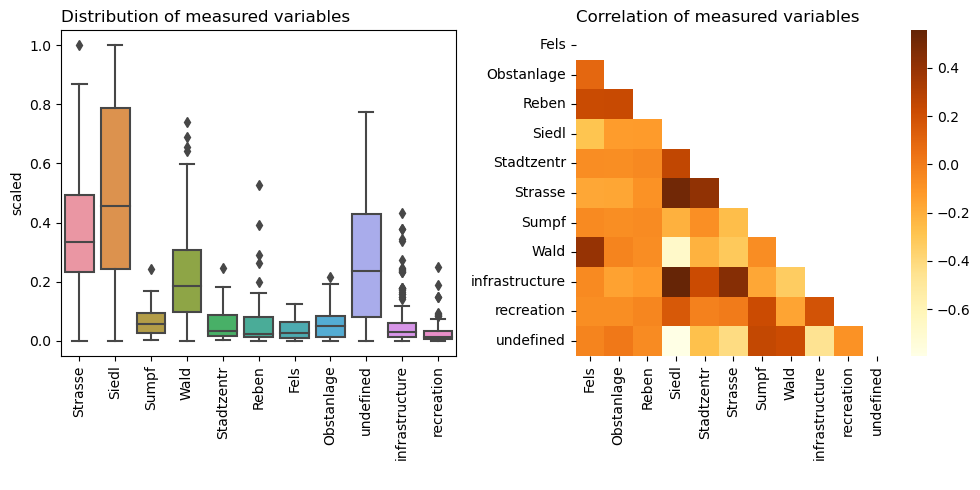

In [26]:
# st_sulpice = land_use_agg.loc[(land_use_agg.=="Saint-Sulpice (VD)")]
# sp = st_sulpice[["magnitude", "scaled", "binned", "use"]]
# uses = sp.use.unique()

columns = [x for x in lu_scaled.columns if x not in ["Geroell", "Stausee"]]
# tst = tst[tst.water_name == wn_map.loc["plage-de-st-sulpice"]]
tst = lu_scaled[columns]
tstx = tst

corr = tstx.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
sns.boxplot(data=land_use_agg[land_use_agg.use.isin(columns)], x="use", y="scaled", ax=ax)
# sns.stripplot(data=sp, x="use", y="scaled", ax=ax, color="magenta", label="Saint-Sulpice (VD)")
ax.set_title("Distribution of measured variables", loc="left")
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel(" ")
# h, l = ax.get_legend_handles_labels()
# ax.legend([h[0]], [l[0]])

sns.heatmap(corr, mask=mask, cmap="YlOrBr", ax=axs[1])

axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_title("Correlation of measured variables", loc="left")
plt.tight_layout()

glue("figure_1_estimate", fig, display=True)
plt.close()

### Additional references for Empirical Bayes and priors

[Bayesian Filtering and Smoothing](https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf) 
Simo S¨arkk¨a (2013). Bayesian Filtering and, Smoothing. Cambridge University Press.

__priors__

1. Empirical Bayesians estimate the prior distribution from the data

__Difference between frequentist an bayes__

|        |Frequentist| Bayesian|
|:-------|:----------|:--------|
|Probability is:|limiting relative frequency| degree of belief|
|Parameter $\theta$ is a: |fixed constant|random variable|
|Probability statements are about:| procedures| parameters|
|Frequency guarantees?| yes | no|

[Doing Byesian Data Analysis](https://jkkweb.sitehost.iu.edu/DBDA.html)
Kruske, John. Doing Bayesian Data Analysis, 2nd Edition. 2015. http://dx.doi.org/10.1016/B978-0-12-405888-0.00002-7

__What is Bayes__

1. Bayesian data analysis has two foundational ideas. The first idea is that Bayesian inference is reallocation of credibility across possibilities. The second foundational idea
is that the possibilities, over which we allocate credibility, are parameter values in meaningful mathematical models.



### Example informed and uninformed priors

It is unclear to what degree the posterior distribution changes when using the informed prior and the uninformed prior. That is: we do not know how the answers to the research questions change when the prior data changes. The prior data is from the existing data set, therefore the prior data can be selected by a _measured-land-use-attribute_ or a collection of land-use attributes. After the amount of land occupied by water, the next most important land-cover attributes are buildings and undefined. Note that these two attributes are negatively corollated, suggesting that a selection for one is an exclusion of the other.

__Example uninformed prior: Lake Geneva, fragmented plastics (Gfrags)__



In [14]:
def when_k_is_zero(x, n):
    if x == 0:
        return 1/n
    if x == n:
        return (x+1)/n
    else:
        return x/n 

def period_pieces(start, end, data, code):
    # the results in pieces per meter for one code from a subset of data
    date_mask = (data["date"] >= start) & (data["date"] <= end)
    period_one = data[date_mask & (data.code == this_code)]
    pone_pcs = period_one.pcs_m.values

    return pone_pcs

def period_k_and_n(data, xrange, add_one=False):

    pone_k = [(data >= x).sum() for x in xrange]
    pone_notk = [(data < x).sum() for x in xrange]

    if add_one:
        # if the use is for beta dist. This is the same
        # as mulitplying the likelihood * uninform prior (0.5) or beta(1,1)
        pone_k_n_minus_k = [(x+1, len(data) - x+1) for x in pone_k]
    else:
        pone_k_n_minus_k = [(x, len(data) - x) for x in pone_k]
        
    

    return np.array(pone_k), np.array(pone_notk), np.array(pone_k_n_minus_k)

def period_beta(k):
         
    if k[0] == 0 or k[1] == 0:
        newk = k[0] + 1
        nminusk = k[1] + 1
        
        return beta(newk, nminusk)
        
    else:
        return beta(k[0], k[1])
        
def p_and_not_p(n, k, not_k):
    p = np.array([when_k_is_zero(x, n) for x in k])
    not_p = np.array([when_k_is_zero(x, n) for x in not_k])

    return p, not_p

def likelihood_times_prior(p, not_p, prior):
    lhp = p*prior    
    lhp_complement = (1-p)*(1-prior)  
    
    total_probability = lhp + lhp_complement 
    k_ui = lhp/total_probability

    return k_ui, lhp, lhp_complement

def minimize_alpha_beta_beta(x, mu, var):
    
    alpha, beta = x[0], x[1]
        
    # define the mean and variance in terms of the parameters
    # mean or mu
    m = alpha/(alpha+beta)    
    
    # standard deviation
    v =  (alpha*beta)/(((alpha+beta)**2)*(alpha+beta+1))
    
    return [m - mu, v - var]

def current_possible_prior_locations(data, landuse, city, attribute):
    

    # indentify the magnitude(s) of the attribute of interest from the
    # locations in the current data there may be more than one, in this 
    # example we use all the possible magnitudes for the attribute
    locations = d[d.city == city].location.unique()

    # magnitudes for the attribute from all the locations in the municipality
    moa = magnitude_of_attribute = landuse.loc[locations][attribute].unique().astype('int')

    # identify locations that have the same attribute by magnitude of attribute
    possible_locations = landuse[landuse[attribute].isin(moa)].index

    # remove the locations that are in the likelihood function
    prior_locations = [x for x in possible_locations if x not in locations]

    return locations, possible_locations, prior_locations


In [15]:
index = 0
this_code =  toi[index]
d = adlu[adlu.water_name_slug == 'lac-leman'].copy()
xrange =  np.arange(0.0, 10, step=.01)
uninformed_prior = np.array([0.5 for x in xrange])

pone_start, pone_end = make_date_object("2015-11-15"), make_date_object("2018-05-01")

# period two
ptwo_start, ptwo_end = make_date_object("2020-04-01"), make_date_object("2021-05-01")

# all data
data_args = {
    'start':pone_start,
    'end':ptwo_end,
    'data': d,   
    'code':this_code
}

period_all = period_pieces(*data_args.values())
pall_k, pall_notk, pall_k_n_minus_k = period_k_and_n(period_all, xrange)

# beta distribution
pall_beta = [period_beta(x) for x in pall_k_n_minus_k]
pall_bmean = [x.mean() for x in pall_beta]

# grid approximation
pall_p , pall_not_p = p_and_not_p(len(period_all), pall_k, pall_notk)
kall_ui , lhpall, lhp_complementall = likelihood_times_prior(pall_p , pall_not_p, uninformed_prior)

cd = d[(d.date <= ptwo_end)&(d.code == this_code)].pcs_m.values
test_observed = cbd[(cbd.Project == 'Testing')&(cbd.code == this_code)]['pcs/m'].values
# data frame
dfdata = {'likelihood': pall_p, 'prior': uninformed_prior, 'grid posterior': kall_ui, 'beta posterior': pall_bmean}

test_results_df = pd.DataFrame(dfdata, index=xrange)
test_results_df['grid normed'] = test_results_df['grid posterior']/test_results_df['grid posterior'].sum()
test_results_df['beta normed'] = test_results_df['beta posterior']/test_results_df['beta posterior'].sum()

In [16]:
fig, ax = plt.subplots()

ax.plot(xrange, kall_ui, c="magenta", linestyle=":", linewidth=4, zorder=20, label='Posterior grid apprximation')
ax.plot(xrange, pall_bmean, c="black", label="Beta posterior",  linewidth=4)
# ax.plot(xrange, prior_bmean, c="red", label="Beta p",  linewidth=4)
# ax.plot(xrange, gi, c="blue", label="Beta p",  linewidth=4)
# observed
sns.histplot(cd, ax=ax, stat="probability", label=f'Observed training data: {this_code}, n={len(cd)}')

ax.set_xlim(-.5, 6)
ax.legend()
ax.set_xlabel('pcs/m')
glue('uninformed_prior_example', fig, display=False)
plt.close()

In [17]:
fig, ax = plt.subplots()

rng_beta=np.random.default_rng()
rng_grid = np.random.default_rng()

predicted_beta = rng_beta.choice(xrange, 100, replace=True, p=test_results_df['beta normed'].values)
predicted_grid = rng_grid.choice(xrange, 100, replace=True, p=test_results_df['grid normed'].values)
# posterior distributions uninformed
ax.plot(xrange, kall_ui,c="magenta", linestyle=":", linewidth=4, zorder=20, label='Posterior grid approximation')
ax.plot(xrange, pall_bmean, c="dodgerblue", label="Beta posterior", linewidth=4)

# observed
sns.histplot(test_observed, ax=ax, stat="probability", label=f'Observed test data: {this_code}, n={len(test_observed)}')
sns.histplot(predicted_grid, ax=ax, stat="probability", label=f'Predicted grid : {this_code}, n={len(predicted_grid)}')

ax.set_xlim(-.5, 6)
ax.legend()
ax.set_xlabel('pcs/m')

glue('test_data_example', fig, display=False)
plt.close()

In [18]:
new_data = [*test_observed, *cd]

new_k, new_notk, new_k_n_minus_k = period_k_and_n(new_data, xrange)

# beta distribution
new_beta = [period_beta(x) for x in new_k_n_minus_k]
pall_bmean = [x.mean() for x in new_beta]

# grid approximation
new_p , new_not_p = p_and_not_p(len([*test_observed, *cd]), new_k, new_notk)
new_ui , new_pall, new_complementall = likelihood_times_prior(new_p , new_not_p, uninformed_prior)

fig, ax = plt.subplots()

ax.plot(xrange, new_ui, c="dodgerblue", label="Expected distribution 2024", linewidth=4)
ax.plot(xrange, kall_ui, c="magenta", linestyle=":", linewidth=4, zorder=20, label='Posterior grid approximation')

sns.histplot([*test_observed, *cd], ax=ax, stat="probability", label=f'All samples 2015-2022: {this_code}, n={len(new_data)}')

ax.set_xlim(-.5, 6)
ax.legend()
ax.set_xlabel('pcs/m')

glue('new_beliefs', fig, display=False)
plt.close()

<!-- ```{glue:figure} uninformed_prior_example
:name: uninformed_prior_example

{glue:text}`blank_caption`
```
{numref}`Figure %s: <uninformed_prior_example>` The expected distribution of the grid approximation is approximately equal to the solution if we used a Beta distribution to the model sample results. The observed test data appears to be a better fit to the posterior distribution than the observed data. -->


|       |  |
|--------------------------------------------------------|-------------------------------------------|
|{glue:}`uninformed_prior_example`                       | {glue:}`test_data_example`         |
|{glue:}`new_beliefs`                                    | words


__Example informed prior: Saint Sulpice, fragmented plastics (Gfrags)__

In [19]:
# make an informed prior distribution
city = cois[0]
attribute = 'Siedl'

# define the data of interest, the likelihood data
d = adlu[adlu.city == city].copy()
lake_locations = adlu[adlu.water_name_slug == lake].location.unique()
land_use_data_of_interest = lucopy.loc[lake_locations]

locations, possible_locations, prior_locations = current_possible_prior_locations(d, land_use_data_of_interest, city, attribute)
# slice the prior data with the end training date, the possible locations and the code of interest
# the data for the prior must be less than the end of training date and it must come from locations
# that have similar values for space appropriated to buildings

data_args = {
    'start':pone_start,
    'end':ptwo_end,
    'data': adlu[(adlu.water_name_slug == lake)& (adlu.location.isin(prior_locations))],
    'code':this_code
}

# mask_location_date = (adlu['date'] <= end_training_date) & (adlu.location.isin(prior_locations))
# mask_code_region = (adlu.code == this_code)
# prior_data = adlu[mask_location_date & mask_code_region]
prior_pcs = period_pieces(*data_args.values())

# get n and k for the prior data
prior_k, prior_notk, prior_k_n_minus_k = period_k_and_n(prior_pcs, xrange)
prior_p, prior_not_p = p_and_not_p(len(prior_pcs), prior_k, prior_notk)

# the grid approximation of the expected distribution of the prior data
prior_ui, prior_lhp, prior_complement = likelihood_times_prior(prior_p, prior_not_p, uninformed_prior)

# the uninformed beta approximation of the prior data
prior_beta = [period_beta(x) for x in prior_k_n_minus_k]
prior_bmean = [x.mean() for x in prior_beta]

# the informed beta apporximation using scaled parameters
# ghv = [tuple(optimize.root(minimize_alpha_beta_beta, [100,100], args=(x, .01)).x) for x in prior_p]
# prior_beta_g = [period_beta(x) for x in ghv]
# p_g = [x.mean() for x in prior_beta_g]

# all data
data_args = {
    'start':pone_start,
    'end':ptwo_end,
    'data': d,   
    'code':this_code
}

# all of the observed results for Saint Sulpice in the training data
period_all = period_pieces(*data_args.values())

# grid approximation of survey data
# k, not k, n-k for the observed values on the xrange
pall_k, pall_notk, pall_k_n_minus_k = period_k_and_n(period_all, xrange)
pall_p, pall_not_p = p_and_not_p(len(period_all), np.array(pall_k), np.array(pall_notk))
# prior_px, prior_not_px = p_and_not_p(len(period_all), pall_k, pall_notk)
uninformed_grid_approximation , lhpalli, lhp_complementalli = likelihood_times_prior(pall_p, pall_not_p, uninformed_prior)

# beta distribution of observed data not scaled
pall_beta = [period_beta(x) for x in pall_k_n_minus_k]
pall_bmean = [x.mean() for x in pall_beta]

# grid approximation of informed prior
# the prior data is scaled to the size 
# of the likelihood data
# note this does not work if we scale just the prior
# and then add it to the results of all the data
scale = len(period_all)/len(prior_pcs)
g = np.array(pall_k_n_minus_k) + np.array(prior_k_n_minus_k)
g_prox = np.array([(x[0], x[0]+x[1]) for x in  g])
scaled_informed_grid = np.array([(x[0]/x[1]) for x in g_prox])
informed_scaled_grid_approximation, lhpall, lhp_complementall = likelihood_times_prior(scaled_informed_grid, 1-scaled_informed_grid, uninformed_prior)


# note this does not work if we scale just the prior
# and then add it to the results of all the data
g_not_scaled = np.array(pall_k_n_minus_k) + np.array(prior_k_n_minus_k)
g_prox_ns = np.array([(x[0], x[0]+x[1]) for x in  g_not_scaled])
grid_ns = np.array([(x[0]/x[1]) for x in g_prox_ns])
grid_ns_approx,_,_ = likelihood_times_prior(grid_ns, 1-grid_ns, prior_ui)

# the beta solution
beta_ns = [period_beta(x) for x in g_not_scaled]
beta_mean_ns = [x.mean() for x in beta_ns]


# g2 = np.array(pall_k_n_minus_k) + ghv
# # pall_p , pall_not_p = p_and_not_p(len(prior_pcs) + len(period_all), np.array(pall_k)+prior_k, np.array(pall_notk)+prior_notk)
# # informed_grid_approximation, lhpall, lhp_complementall = likelihood_times_prior(pall_p , pall_not_p, uninformed_prior)

# beta distribution of k and n-k of all the data
# from Saint Sulpice and the scaled n, n-k parameters from
# the prior data. Recall the prior data consists of locations
# with similar amounts of space allocated to buildings
informed_beta = [period_beta(x) for x in g]

# take the mean value of the proposed beta distribution
# for each value between 0.00 and 9.99. Recall the
# the mean of the Beta distribution is the expected value
# of theta for the Binomial distribution
informed_bmean = [x.mean() for x in informed_beta]

# a data frame of the results
# collect the likelihoods and parameter estimates from the tests
dfdata = {
    'likelihood': pall_p, 
    'prior': prior_ui, 
    'ui_posterior': uninformed_grid_approximation,    
    'i_scaled_post': informed_scaled_grid_approximation,
    'beta_posterior': informed_bmean
}  

# index on xrange
results_df = pd.DataFrame(dfdata, index=xrange)

# normalize the informed grid approximation
results_df['normed'] = results_df['i_scaled_post']/results_df.i_scaled_post.sum()

# sample the proposed distribution
rng=np.random.default_rng()
predicted = rng.choice(xrange, len(prior_pcs), replace=True, p=results_df.normed.values)

# the observed values from the training data
cd = d[(d.date <= ptwo_end)&(d.code == this_code)].pcs_m.values
test_sp = cbd[(cbd.Project =='Testing') & (cbd.code == this_code) & (cbd.location.isin(locations))]['pcs/m'].values

In [20]:
gelman = np.array(pall_k_n_minus_k) + np.array(prior_k_n_minus_k)
lhx = list(zip(pall_k, pall_notk))
def make_expected(lh_tuple, prior_tuple, xrange):
    res = []
    for i in np.arange(len(xrange)):
        numerator = lh_tuple[i][0] + prior_tuple[i][0]
        denominator = lh_tuple[i][0]  + sum(prior_tuple[i])
        expected = numerator/denominator
        res.append(expected)
    return res
        
prob = [(x[0]+gelman[i][0])/(x[1]+gelman[i][0] + gelman[i][1]) for i,x in enumerate(lhx)]
probi = make_expected(lhx, gelman, xrange)

In [21]:
# fig,ax = plt.subplots(figsize=(8,6))


# ax.plot(xrange, uninformed_grid_approximation, c="aqua", zorder=12, linestyle=":",linewidth=2, label=f'Observed grid approximation, n={len(period_all)}')
# ax.plot(xrange, prior_ui, c="gold",  linestyle=":",linewidth=2, zorder=12, label=f'Prior grid approximation, n={len(prior_pcs)}')
# # ax.plot(xrange, informed_scaled_grid_approximation, c="lime", linestyle=":", zorder=12, linewidth=3, label=f'Posterior grid scaled, scale={len(period_all)}/{len(prior_pcs)}')

# sns.scatterplot(x=xrange, y=probi, marker='x', c='red', zorder=12, label='Estimated posterior')
# # sns.scatterplot(x=xrange, y=beta_mean_ns, marker='x', c='darkred', zorder=10, label="Beta posterior not scaled")

# ax.plot(xrange, pall_bmean, c="blue", label=f'Beta distribtuin observed', linewidth=3, zorder=10)
# ax.plot(xrange, prior_bmean, c="black", label="Beta distribution prior", linewidth=3, zorder=10 )
# # ax.plot(xrange, informed_bmean, c="green",  linewidth=4, zorder=10, label=f'Posterior beta scaled, scale={len(period_all)}/{len(prior_pcs)}')


# #observed
# sns.histplot(prior_pcs, ax=ax, stat="probability", label=f'Prior data: {this_code}, {len(prior_pcs)} samples')

# ax.legend()
# ax.set_xlabel("pcs/m")
# ax.set_ylabel("probability")
# ax.set_xlim(-.1, 6)
# ax.set_ylim(-.05, 1)
# plt.savefig("question_cvalidated2.jpeg")
# plt.show()

In [22]:
# prior grid approximations
fig, ax = plt.subplots()

# grid approximations
ax.plot(xrange, prior_ui, c="magenta", linestyle=':', linewidth=4, label="Prior grid approximation", zorder=16)

# beta approximations
ax.plot(xrange, prior_bmean, c="dodgerblue", label="Beta prior", linewidth=4)

# observed
sns.histplot(prior_pcs, ax=ax, stat="probability", label=f'prior data: {this_code}, n={len(prior_pcs)}')
ax.set_xlabel('pcs/m')
ax.set_xlim(.5, 6)
ax.legend()
glue('city_prior_data', fig, display=False)
plt.close()

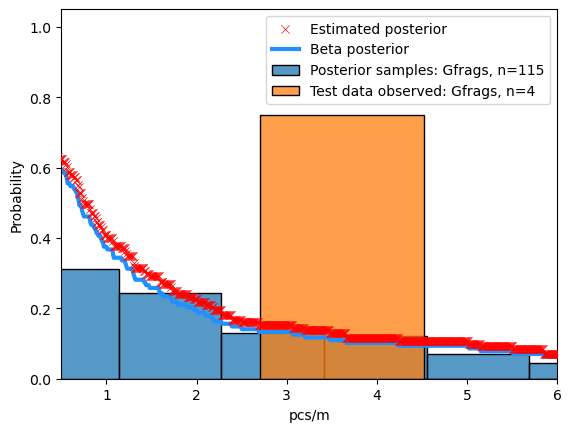

In [23]:
# # make a new distribution with the test and training data
# new_data = [*test_observed, *cd]

# new_k, new_notk, new_k_n_minus_k = period_k_and_n(new_data, xrange)

# # beta distribution
# new_beta = [period_beta(x) for x in new_k_n_minus_k]
# pall_bmean = [x.mean() for x in new_beta]

# # grid approximation
# new_p , new_not_p = p_and_not_p(len([*test_observed, *cd]), new_k, new_notk)
# new_ui , new_pall, new_complementall = likelihood_times_prior(new_p , new_not_p, uninformed_prior)

fig, ax = plt.subplots()

# grid approximations
sns.scatterplot(x=xrange, y=probi, marker='x', c='red', zorder=12, label='Estimated posterior')

# beta approximations
ax.plot(xrange, informed_bmean, c="dodgerblue",  linewidth=3, label="Beta posterior")

# posterior predictive
sns.histplot(predicted, ax=ax, stat="probability", label=f'Posterior samples: {this_code}, n={len(predicted)}')

# observed
sns.histplot(test_sp, ax=ax, stat="probability", label=f'Test data observed: {this_code}, n={len(test_sp)}')
ax.set_xlabel('pcs/m')
ax.set_xlim(.5, 6)
ax.legend()
glue('city_posterior', fig, display=True)
plt.close()

|                                                        |                                           |
|--------------------------------------------------------|-------------------------------------------|
|{glue:}`city_prior_data`                                | {glue:}`city_posterior`                   |
|describe                                                | describe                                  |

## Implementation and results

For this initial study we are directly calculating the probability of an event given the events described in the survey results. The result is a point estimate of the probability of that event, given the data and the prior probability of that event.

### Lake Geneva

>_Given the data from 2022, Is there an increase, decrease or no change in the expected survey results given the consolidated results from 2015 - 2021?_

>_Given the median value for the objects of interest in 2021, what is the chance that a survey in 2022 will exceed this value?_

>_How do the results from 2022 change the expected survey results going forward?_
### Saint Sulpice

>_Given the data from 2022, Is there an increase, decrease or no change in the expected survey results given the consolidated results from 2015 - 2021?_

>_Given the median value for the objects of interest in 2021, what is the chance that a survey in 2022 will exceed this value?_

>_How do the results from 2022 change the expected survey results going forward?_


### Inference tables

Inference tables are Grid approximations made from a series of point estimates calculated using Bayes theorem. Instead of calculating the probability of every event, we calculate points at fixed intervals between a minimum and maximum range of probable values. The minimum is zero, for this study we set the maximum to 1000 p/100 m or 10 p/m. The maximum can be defined by the data, taking the 99th percentile for example. This method is 100% inspired by Alan Downeys example using _python_ : [Think Bayes 2](https://allendowney.github.io/ThinkBayes2/chap02.html) and using _R_ : [Approximating the posterior](https://www.bayesrulesbook.com/chapter-6.html) in _Bayes Rules! An Introduction to Applied Bayesian Modeling_. Grid approximations leverage basic array functionality and make it easy to implement different methods for handling the priors. Recal that there are two  hypothesis for each event: _h = the threshhold was exceeded_, _h1 = the threshhold was not exceeded_. ([Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) ([conditional proabability](https://en.wikipedia.org/wiki/Conditional_probability)). 

#### The grid

There is a grid for each code. The grid contains the density in pcs/m, the likelihood of the event, the prior probability of the event and the calculations required to determine the posterior probability of the event. There are 1000 rows in each grid or one row for every .01 in the range of 0.00 to 9.99.  

## Discussion

## Conclusions

### Next steps

### Participating organizations

### Financial disclosure



In [24]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 12/08/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [25]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/patelmanuscript.git

Git branch: newsummary

seaborn   : 0.12.2
pandas    : 2.0.2
matplotlib: 3.7.1
numpy     : 1.24.3
scipy     : 1.10.1

